# Base de Dados

In [1]:
!wget https://archive.ics.uci.edu/static/public/374/appliances+energy+prediction.zip -O energy_data.zip
!unzip energy_data.zip

--2025-11-06 14:11:19--  https://archive.ics.uci.edu/static/public/374/appliances+energy+prediction.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘energy_data.zip’

energy_data.zip         [  <=>               ]  11.42M  2.01MB/s    in 23s     

2025-11-06 14:11:42 (515 KB/s) - ‘energy_data.zip’ saved [11979507]

Archive:  energy_data.zip
 extracting: energydata_complete.csv  


In [2]:
import pandas as pd
try:
    df = pd.read_csv('energydata_complete.csv')
except FileNotFoundError:
    print("Arquivo não encontrado, simulando dados...")
    df = pd.DataFrame(np.random.rand(1000, 10), columns=['date', 'Appliances', 'T1', 'RH_1', 'T_out', 'Press_mm_hg', 'Windspeed', 'lights', 'T2', 'RH_2'])
    df['date'] = pd.date_range(start='2016-01-11 17:00:00', periods=1000, freq='10min')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [3]:
!pip3 install tensorflow.keras

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler # Usado apenas para simulação
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Pré Processamento


In [18]:


# converter data e setar índice
# We can reset the index before converting to datetime and sorting.
df = df.reset_index()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)


# selecionar features relevantes (Exemplo)
target_col = 'Appliances'
feature_cols = ['T1', 'RH_1', 'T_out', 'Press_mm_hg', 'Windspeed', 'lights']
all_cols = [target_col] + feature_cols # Lista completa de colunas que vamos usar

# Criar o DataFrame final (sem NAs)
df_model = df[all_cols].dropna()

# --- 2. Divisão Treino/Teste (ANTES de Escalonar) ---
split_fraction = 0.8
split_idx = int(len(df_model) * split_fraction)

train_data = df_model.iloc[:split_idx]
test_data = df_model.iloc[split_idx:]

print(f"Amostras de Treino: {len(train_data)}")
print(f"Amostras de Teste: {len(test_data)}")

# --- 3. Escalonar Features  ---
# O MinMaxScaler é o foco aqui.
scaler = MinMaxScaler()
scaler.fit(train_data)

scaler_target = MinMaxScaler()
scaler_features = MinMaxScaler()

# O 'scaler_target' aprende o Mín/Máx SOMENTE de 'Appliances' do treino.
# O 'scaler_features' aprende o Mín/Máx das features do treino.

# Nota: [[target_col]] é usado para manter o formato 2D (DataFrame)
scaler_target.fit(train_data[[target_col]])
scaler_features.fit(train_data[feature_cols])

# Transformar (Transform) ambos os conjuntos (Treino e Teste)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

# O resultado (train_scaled, test_scaled) são arrays NumPy,não mais DataFrames Pandas.
#print(f"\nFormato dos dados de treino escalonados: {train_scaled.shape}")

# --- 4. Criar Sequências ---
def create_sequences(data, look_back, forecast_horizon, target_index):
    """
    Cria sequências para RNNs.
    :param data: Array 2D (já escalonado) de features
    :param look_back: Quantos passos olhar para trás (ex: 24)
    :param forecast_horizon: Quantos passos prever à frente (ex: 1)
    :param target_index: O índice da coluna do seu target (em 'all_cols', 'Appliances' é 0)
    """
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        # Janela de features de entrada
        feature_window = data[i : (i + look_back), :] # Todas as colunas
        # Target de saída
        target_window = data[i + look_back : i + look_back + forecast_horizon, target_index]

        X.append(feature_window)
        y.append(target_window)

    return np.array(X), np.array(y)

# Parâmetros da Janela
LOOK_BACK = 6*10       # Usar 24 passos (24 * 10min = 4 horas) para prever
FORECAST_HORIZON = 1 # Prever 10 min à frente
TARGET_INDEX = 0

# Criar as sequências
X_train, y_train = create_sequences(train_scaled, LOOK_BACK, FORECAST_HORIZON, TARGET_INDEX)
X_test, y_test = create_sequences(test_scaled, LOOK_BACK, FORECAST_HORIZON, TARGET_INDEX)

print(f"\nFormato de X_train (Amostras, Passos, Features): {X_train.shape}")
print(f"Formato de y_train (Amostras, Horizonte): {y_train.shape}")

# X_train.shape será (amostras, 24, 7)
# 24 = LOOK_BACK
# 7 = Nossas features (Appliances + 6 outras)

Amostras de Treino: 15788
Amostras de Teste: 3947

Formato de X_train (Amostras, Passos, Features): (15728, 60, 7)
Formato de y_train (Amostras, Horizonte): (15728, 1)


##Construindo o Modelo


In [19]:
import tensorflow as tf

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = tf.keras.models.Sequential([
    # Camada LSTM com 50 unidades.
    # a ativação padrão 'tanh' é geralmente preferida. Vamos manter 'relu'
    tf.keras.layers.LSTM(50, input_shape=(n_timesteps, n_features)), # Use n_features here

    # Camada de saída com 1 neurônio (para prever 1 valor: 'Appliances')
    tf.keras.layers.Dense(1)
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,651 (45.51 KB)

 Trainable params: 11,651 (45.51 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='adam', loss='mse') # 'mse' é 'mean_squared_error'

print("Modelo compilado.")

Modelo compilado.


##Treinando o Modelo

In [21]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    validation_data=(X_test, y_test), # O jeito certo para séries temporais
    verbose=1 # Mude para 0 se não quiser ver o output de cada época
)

print("Treinamento concluído.")

Epoch 1/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0091 - val_loss: 0.0034
Epoch 2/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 3/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 4/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 5/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 7/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 8/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 9/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 10/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 11/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 12/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

##Avaliando o Modelo

In [22]:
# 1. Avaliar a perda (loss) no conjunto de teste (valor escalonado)
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE escalonado): {loss}')

# 2. Fazer previsões (ainda na escala [0, 1])
predictions_scaled = model.predict(X_test)

# 3. Reverter a transformação (MUITO IMPORTANTE)
# (Usando o 'scaler_target' que guardamos)
predictions = scaler_target.inverse_transform(predictions_scaled)
y_test_original = scaler_target.inverse_transform(y_test)

# 4. Calcular métricas na escala original (Watts)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)

print(f"\n--- Métricas na Escala Original ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} Watts")
print(f"MAE (Mean Absolute Error):    {mae:.2f} Watts")

Test Loss (MSE escalonado): 0.0028850813396275043
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- Métricas na Escala Original ---
RMSE (Root Mean Squared Error): 57.47 Watts
MAE (Mean Absolute Error):    25.92 Watts


##Visualizando Resultados

Variáveis 'predictions_scaled', 'y_test' e 'scaler_target' encontradas.

Revertendo o escalonamento para a escala original (Watts)...
Escala revertida com sucesso.

Gerando plot de comparação Real vs. Previsto...


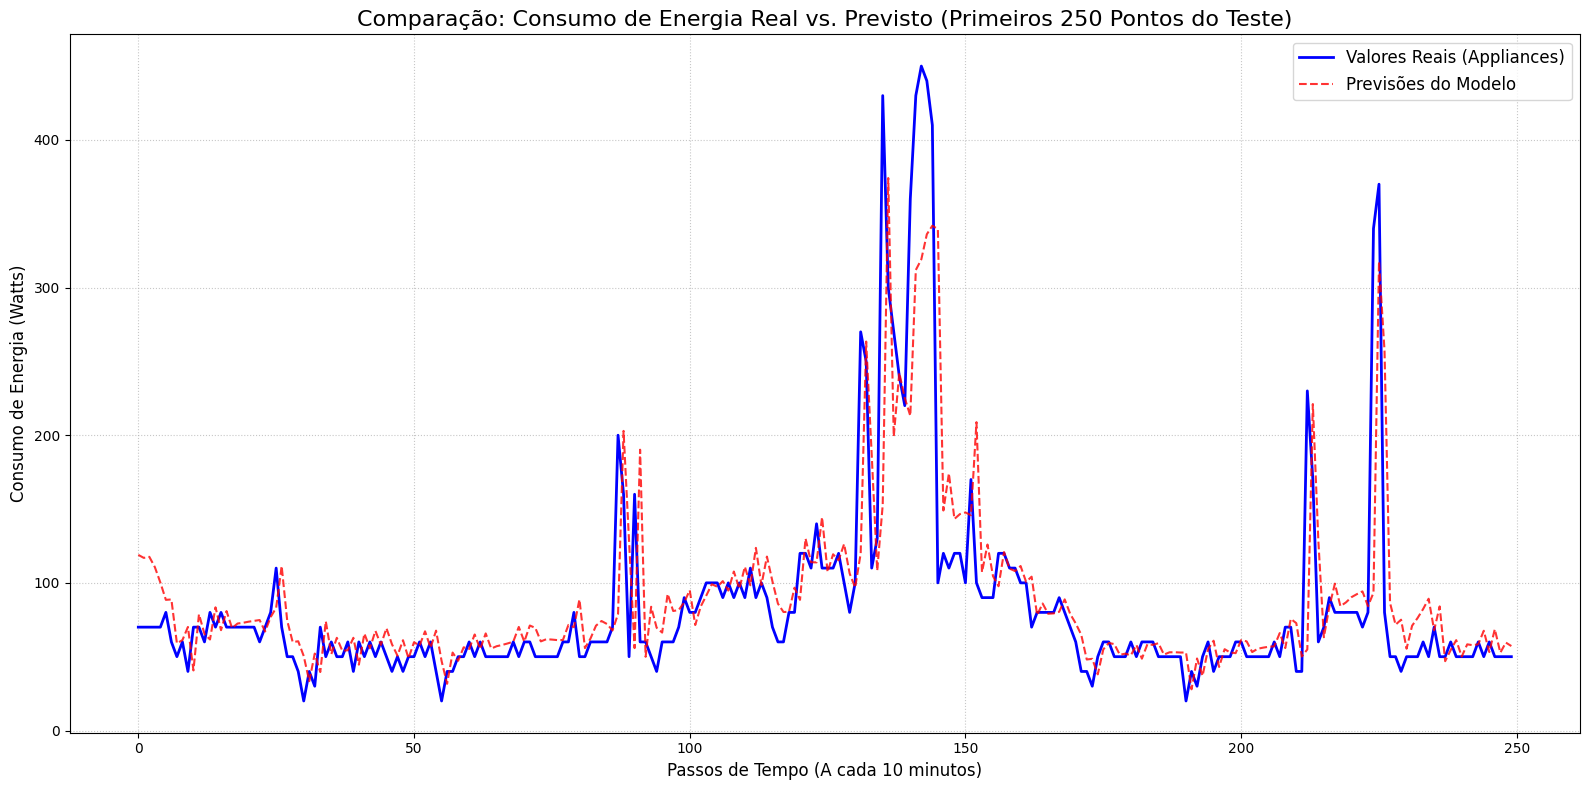


Visualização concluída.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

predictions_scaled.shape
y_test.shape
scaler_target
print("Variáveis 'predictions_scaled', 'y_test' e 'scaler_target' encontradas.")


# --- 2. Reverter o escalonamento para obter os valores em sua escala original (Watts) ---
print("\nRevertendo o escalonamento para a escala original (Watts)...")
predictions_real = scaler_target.inverse_transform(predictions_scaled)
y_test_real = scaler_target.inverse_transform(y_test)

print("Escala revertida com sucesso.")

# --- 3. Plotar os resultados ---
print("\nGerando plot de comparação Real vs. Previsto...")

# Vamos plotar uma porção dos dados de teste para melhor visualização
# Ajuste 'plot_samples' conforme necessário.
plot_samples = 250 # Plotar os primeiros X pontos do conjunto de teste

plt.figure(figsize=(16, 8))
plt.plot(y_test_real[:plot_samples], label='Valores Reais (Appliances)', color='blue', linewidth=2)
plt.plot(predictions_real[:plot_samples], label='Previsões do Modelo', color='red', linestyle='--', alpha=0.8)

plt.title(f'Comparação: Consumo de Energia Real vs. Previsto (Primeiros {plot_samples} Pontos do Teste)', fontsize=16)
plt.xlabel('Passos de Tempo (A cada 10 minutos)', fontsize=12)
plt.ylabel('Consumo de Energia (Watts)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

print("\nVisualização concluída.")